## Set up, library import

In [ ]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plot
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import re
import warnings
warnings.simplefilter('ignore')
import matplotlib
from collections import Counter
print('matplotlib: {}'.format(matplotlib.__version__))

In [ ]:
pip install matplotlib --upgrade

In [ ]:
con = sqlite3.connect("/content/mental_health.sqlite")

## Exploratory Data Analysis

## Gender & Age

In [ ]:
GA_df = pd.read_sql(
      """ WITH table1 AS(
                SELECT DISTINCT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 1),
                table2 AS(
                SELECT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 2)
          SELECT t2.UserID, 
                 t2.AnswerText as gender, 
                 t1.AnswerText as age
          FROM table2 t2
          JOIN table1 t1
          ON t1.UserID = t2.UserID
      """,
      con,
      )
GA_df.head()

,UserID,gender,age
0,1,Female,37
1,2,Male,44
2,3,Male,32
3,4,Male,31
4,5,Male,31


In [ ]:
GA_df["age"] = GA_df["age"].astype("int")
GA_df["age"].describe()

count    4207.000000
mean       33.980509
std        10.297182
min         3.000000
25%        28.000000
50%        33.000000
75%        38.000000
max       329.000000
Name: age, dtype: float64

In [ ]:
GA_df = GA_df[(GA_df.age > 15) & (GA_df.age <= 75)]
GA_df["age"].describe()

count    4203.000000
mean       33.855817
std         8.068257
min        17.000000
25%        28.000000
50%        33.000000
75%        38.000000
max        74.000000
Name: age, dtype: float64

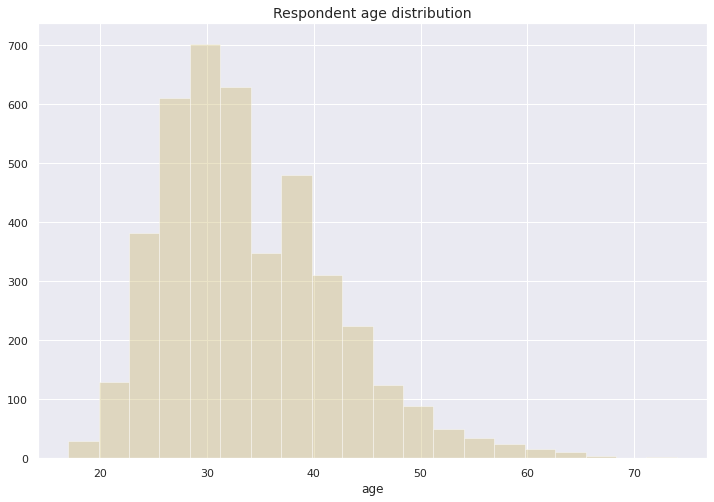

In [ ]:
sns.set()
plt.figure(figsize=(12, 8))
sns.distplot(GA_df["age"], kde=False, color="y", bins=20)
plt.title("Respondent age distribution", fontsize=14)
plt.show()

In [ ]:
GA_df.gender.unique()

array(['Female', 'Male', 'Male-ish', 'Trans-female',
       'something kinda male?', 'queer/she/they', 'non-binary', 'Nah',
       'Enby', 'fluid', 'Genderqueer', 'Androgyne', 'Agender',
       'Guy (-ish) ^_^', 'male leaning androgynous', 'Trans woman',
       'Neuter', 'Female (trans)', 'queer',
       'ostensibly male, unsure what that really means', 'Bigender',
       'Female assigned at birth', 'fm', 'Transitioned, M2F',
       'Genderfluid (born female)', 'Other/Transfeminine',
       'Female or Multi-Gender Femme', 'Androgynous',
       'male 9:1 female, roughly', '-1', 'nb masculine',
       'none of your business', 'genderqueer', 'Human', 'Genderfluid',
       'genderqueer woman', 'mtf', 'Queer', 'Fluid', 'Male/genderqueer',
       'Nonbinary', 'human', 'Unicorn', 'Male (trans, FtM)',
       'Genderflux demi-girl', 'female-bodied; no feelings about gender',
       'AFAB', 'Transgender woman', 'male', 'female', 'male/androgynous',
       'uhhhhhhhhh fem genderqueer?', 'God King

In [ ]:
def replace_gender(x):
    if x in ["male", "female"]:
        return x
    else:
        return "other"


GA_df["gender"] = GA_df["gender"].str.lower().apply(replace_gender)

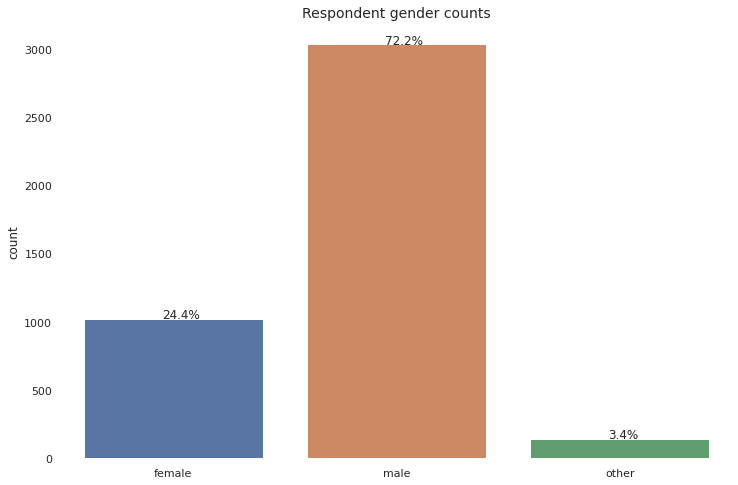

In [ ]:
plt.figure(figsize=(12, 8))
axe = sns.countplot(x="gender", data=GA_df)

total = len(GA_df["gender"])
for p in axe.patches:
    percentage = "{:.1f}%".format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    axe.annotate(percentage, (x, y), size=12)

plt.title("Respondent gender counts", fontsize=14)
sns.despine(bottom=True, left=True)
plt.xlabel("")
plt.show()

For two reasons, the data do not reflect the general population: the gender breakdown is significantly skewed towards men; and the age breakdown is made up mostly of people in their 20s and 30s. 

##Would respondents with a diagnosed mental health disorder be less likely to openly share their mental health diagnosis ?

According to Mental Health in the workplace: Global Impact Study 82% of workers with a diagnosed mental illness do not inform their workplace managers about their condition. The common reasons are fearing the negative impact on their career, being embarrassed, and even losing their job.

In the following chapter I will be comparing how often diagnosed people would talk about mental health in the workplace vs undiagnosed people.


In [ ]:
df = pd.read_sql(
      """ WITH table1 AS(
                SELECT DISTINCT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 34),
                table2 AS(
                SELECT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 12),
                table4 AS(
                SELECT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 19),
                table5 AS(
                SELECT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 18) 
          SELECT t2.UserID,
                 t2.AnswerText as dscss_mh_intrv, 
                 t4.AnswerText as dscss_mh_spr, 
                 t5.AnswerText as dscss_mh_cw,
                 t1.AnswerText as MentalHealthDisorder
          FROM table2 t2
          JOIN table1 t1
          ON t1.UserID = t2.UserID
          JOIN table4 t4
          ON t2.UserID = t4.UserID
          JOIN table5 t5
          ON t2.UserID = t5.UserID
      """,
      con,
      )
df = df[~df.isin(["-1"]).any(axis=1)]
df.head()

,UserID,dscss_mh_intrv,dscss_mh_spr,dscss_mh_cw,MentalHealthDisorder
0,1261,Maybe,Yes,Maybe,Yes
1,1262,No,Yes,Maybe,Yes
2,1263,Yes,Maybe,Maybe,No
4,1265,No,No,Maybe,Yes
5,1266,Maybe,Yes,Maybe,No


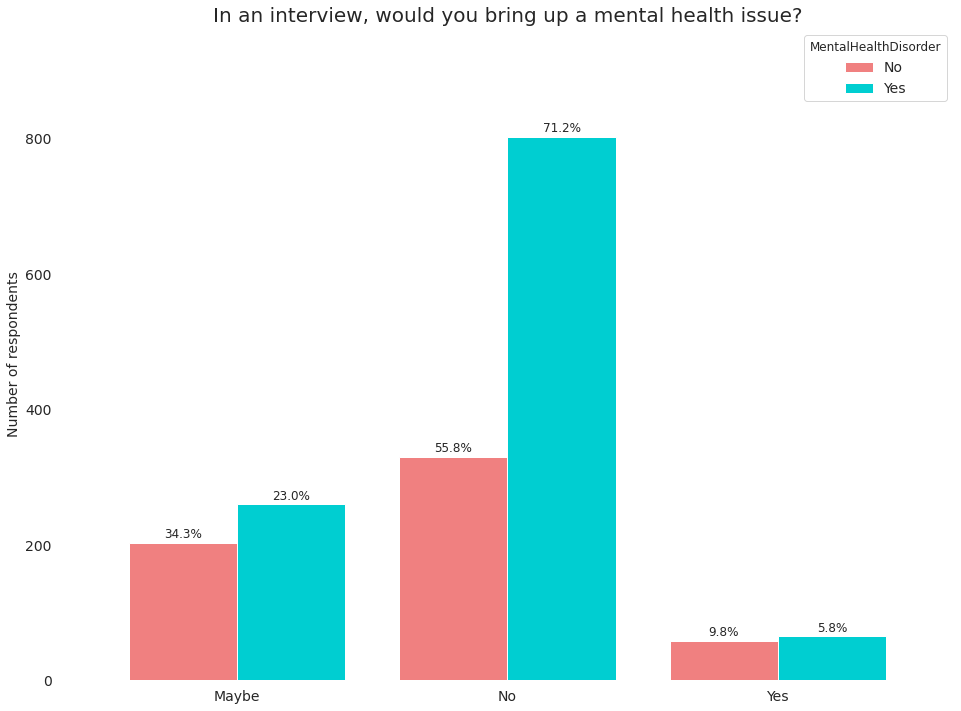

In [ ]:
params = {'legend.fontsize': 14,
          'legend.handlelength': 2}
plot.rcParams.update(params)

q1 = (
    df.groupby(["dscss_mh_intrv", "MentalHealthDisorder"])
    .size()
    .reset_index(name="Counts")
)
q1 = q1.pivot("dscss_mh_intrv", "MentalHealthDisorder", "Counts")
totals = q1.sum()

sns.set_style("white")
ax = q1.plot(
    kind="bar",
    figsize=(16, 12),
    width= 0.8,
    rot=0,
    color=["lightcoral", "darkturquoise"]
)

for tot, p in zip(totals, ax.containers):

    labels = [f"{(v.get_height()/tot)*100:0.1f}%" for v in p]

    ax.bar_label(p, labels=labels, label_type="edge", fontsize=12, rotation=0, padding=2)

ax.margins(y=0.2)
plt.title("In an interview, would you bring up a mental health issue?", fontsize=20)
plt.ylabel("Number of respondents", fontsize=14)
plt.xlabel("")
plt.tick_params(labelsize=14)
sns.despine(bottom=True, left=True)
plt.show()


H0: A respondent's preference for discussing their mental health in interview is independent of whether they have been diagnosed with a mental illness.

H1: It is less comfortable for respondents with a diagnosed mental illness to talk about it in an interview.

In [ ]:
print("P-value: ", chi2_contingency(q1)[1])

P-value:  1.1640088409540893e-09


We reject null hypothesis and can assume that a mental health diagnosis impacts person's willingness to discuss their mental health in an interview.

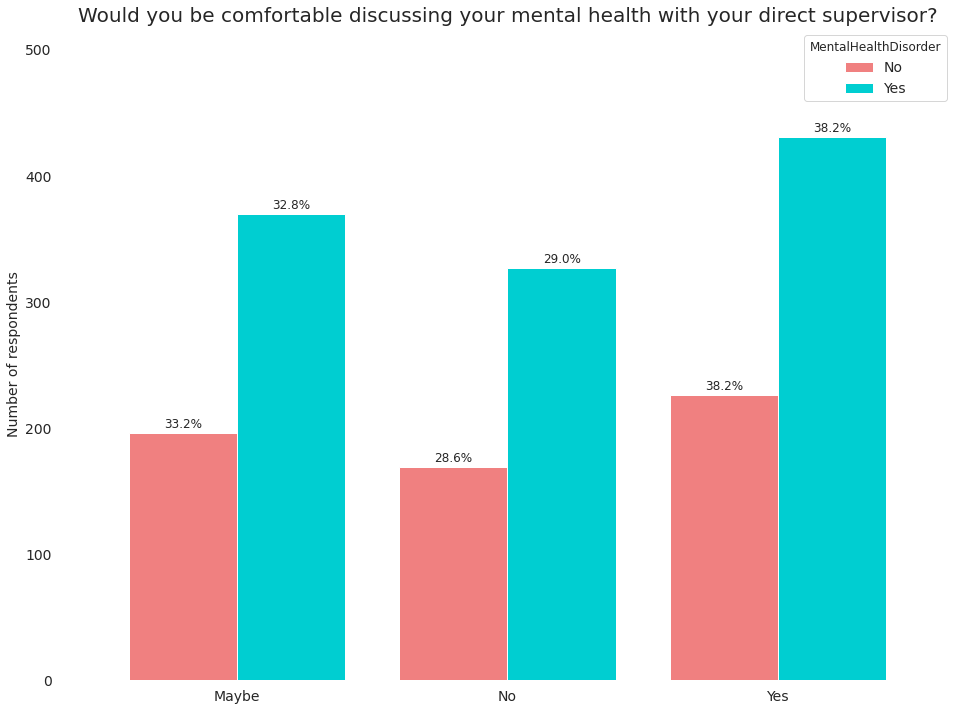

In [ ]:
q2 = (
    df.groupby(["dscss_mh_spr", "MentalHealthDisorder"])
    .size()
    .reset_index(name="Counts")
)
q2 = q2[q2["dscss_mh_spr"] != "-1"]
q2 = q2.pivot("dscss_mh_spr", "MentalHealthDisorder", "Counts")

totals = q2.sum()

ax = q2.plot(
    kind="bar",
    figsize=(16, 12),
    width= 0.8,
    rot=0,
    color=["lightcoral", "darkturquoise"]
)

for tot, p in zip(totals, ax.containers):

    labels = [f"{(v.get_height()/tot)*100:0.1f}%" for v in p]

    ax.bar_label(p, labels=labels, label_type="edge", fontsize=12, rotation=0, padding=2)

ax.margins(y=0.2)
plt.title(
    "Would you be comfortable discussing your mental health with your direct supervisor?",
    fontsize=20,
)
plt.ylabel("Number of respondents", fontsize=14)
plt.xlabel("")
plt.tick_params(labelsize=14)
sns.despine(bottom=True, left=True)
plt.show()


H0: A respondent's preference for discussing their mental health with a supervisor is independent of whether they have been diagnosed with a mental illness.

H1: It is less comfortable for respondents with a diagnosed mental illness to talk about it with their direct supervisors.

In [ ]:
print("P-value: ", chi2_contingency(q2)[1])

P-value:  0.9819487689846875


The null hypothesis cannot be rejected, and we can assume that a person's willingness to speak with their supervisor has nothing to do with whether they are diagnosed with mental illness.

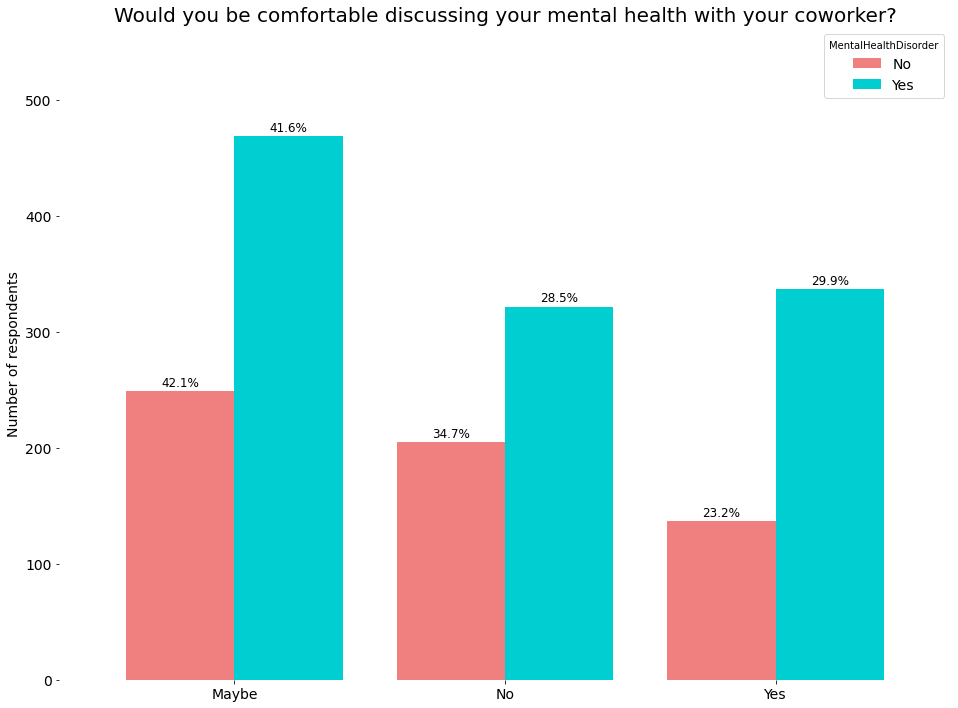

In [ ]:
q3 = (
    df.groupby(["dscss_mh_cw", "MentalHealthDisorder"])
    .size()
    .reset_index(name="Counts")
)
q3 = q3[q3["dscss_mh_cw"] != "-1"]
q3 = q3.pivot("dscss_mh_cw", "MentalHealthDisorder", "Counts")

totals = q3.sum()

ax = q3.plot(
    kind="bar",
    figsize=(16, 12),
    width= 0.8,
    rot=0,
    color=["lightcoral", "darkturquoise"]
)

for tot, p in zip(totals, ax.containers):

    labels = [f"{(v.get_height()/tot)*100:0.1f}%" for v in p]

    ax.bar_label(p, labels=labels, label_type="edge", fontsize=12, rotation=0, padding=2)

ax.margins(y=0.2)
plt.title(
    "Would you be comfortable discussing your mental health with your coworker?",
    fontsize=20,
)
plt.ylabel("Number of respondents", fontsize=14)
plt.xlabel("")
plt.tick_params(labelsize=14)
sns.despine(bottom=True, left=True)
plt.show()


### Results

Here we looked at whether people are willing to talk about mental health in the workplace. We compared answers of those who have been diagnosed with a mental health illness versus those who haven't.

Mental health issues are generally not discussed in an interview, as people prefer not to disclose them. 62% of respondents who are undiagnosed and 70% of those who have been diagnosed would not mention mental health issues. And that is not surprising because opening up about an illness at interview is a red flag for most employers.

Diagnosed and undiagnosed respondents had similar responses when asked if they would be comfortable discussing mental health with their direct supervisors. 38% diagnosed respondents would do that while 29 % would not. When asked the same question but discussing mental health with coworker, diagnosed respondents are slightly more open to do that with 30% answering yes compared to 26% undiagnosed.

According to the results, more respondents would feel more comfortable discussing their mental health with their direct supervisor than their coworker.

We can also assume that a person's willingness to speak with their supervisor has nothing to do with whether they are diagnosed with mental illness.


We can't conclude that the preference to talk or not to talk about mental health depends on the person being diagnosed with mental health issue. Threfore, we will look if there is any impact on the employers provided benefits and workplace culture around mental health.


##Talking about mental health in the work place. Are people more open to talk about mental health issues in workplace if the organisation has a more mentally healthy culture ?

In [ ]:
df3 = pd.read_sql(
      """ WITH table1 AS(
                SELECT DISTINCT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 19),
                table2 AS(
                SELECT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 10),
                table3 AS(
                SELECT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 15),
                table4 AS(
                SELECT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 16),
                table5 AS(
                SELECT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 11),
                table6 AS(
                SELECT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 18)
          SELECT t2.AnswerText as mh_benefits, 
                 t3.AnswerText as discuss_mh,
                 t4.AnswerText as mh_resources,
                 t5.AnswerText as anonymity,
                 t6.AnswerText as discuss_mh_cw,
                 t1.AnswerText as discuss_mh_spr
          FROM table2 t2
          JOIN table1 t1
          ON t1.UserID = t2.UserID
          JOIN table3 t3
          ON t3.UserID = t2.UserID
          JOIN table4 t4
          ON t3.UserID = t4.UserID
          JOIN table5 t5
          ON t4.UserID = t5.UserID
          JOIN table6 t6
          ON t5.UserID = t6.UserID
      """,
      con,
      )
df3.head()

,mh_benefits,discuss_mh,mh_resources,anonymity,discuss_mh_cw,discuss_mh_spr
0,Not eligible for coverage / NA,No,No,I don't know,Maybe,Yes
1,No,Yes,Yes,Yes,Maybe,Yes
2,No,No,No,I don't know,Maybe,Maybe
3,-1,-1,-1,-1,-1,-1
4,Yes,No,No,No,Maybe,No


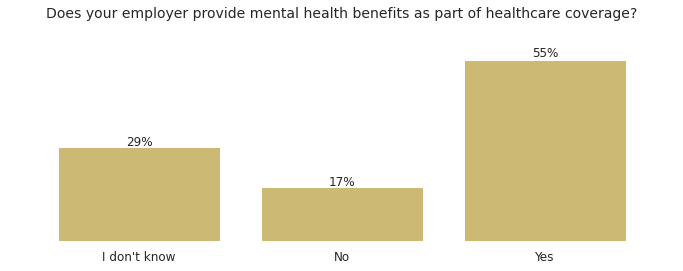

In [ ]:
benefit_df = df3[
    (df3["mh_benefits"] == "Yes")
    | (df3["mh_benefits"] == "No")
    | (df3["mh_benefits"] == "I don't know")
]

s = benefit_df.mh_benefits.value_counts(normalize=True).sort_index()
ax = s.plot(kind="bar", figsize=(12, 4), width=0.8, rot=0, color="y")

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f"{height:.0%}", (x + width / 2, y + height * 1.02), ha="center")

ax.margins(y=0.2)
plt.xticks(fontsize=12)
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.title(
    "Does your employer provide mental health benefits as part of healthcare coverage?",
    fontsize=14,
)
plt.show()

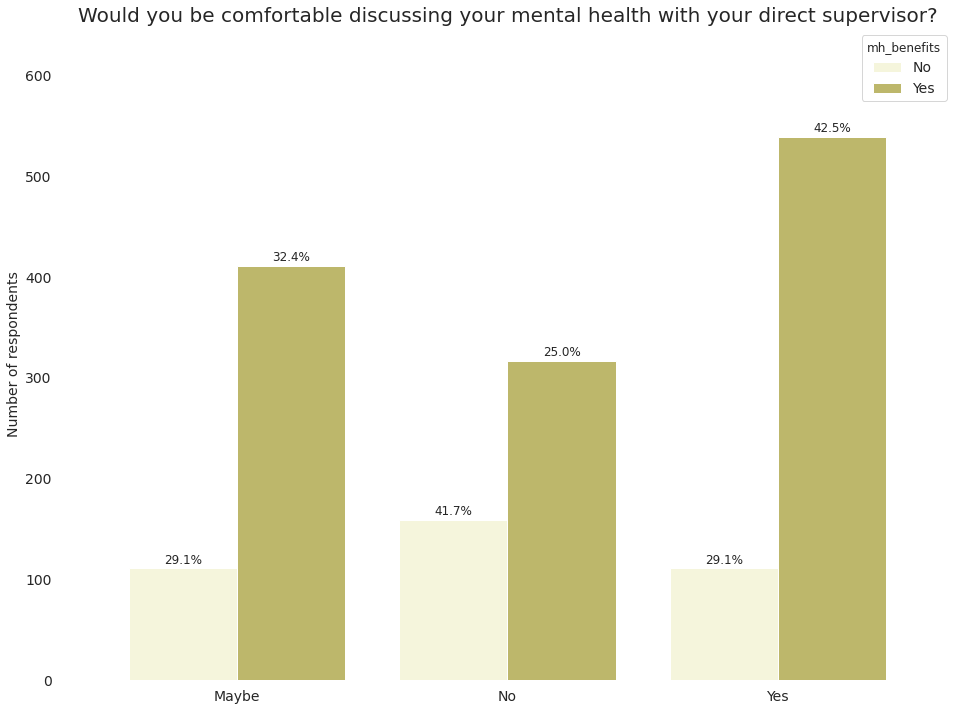

In [ ]:
x = benefit_df[benefit_df["mh_benefits"] != "I don't know"]
x = pd.crosstab(x.discuss_mh_spr, x.mh_benefits, margins=False)

totals = x.sum()

ax = x.plot(
    kind="bar", figsize=(16, 12), width=0.8, rot=0, color=["beige", "darkkhaki"]
)

for tot, p in zip(totals, ax.containers):

    labels = [f"{(v.get_height()/tot)*100:0.1f}%" for v in p]

    ax.bar_label(
        p, labels=labels, label_type="edge", fontsize=12, rotation=0, padding=2
    )

ax.margins(y=0.2)
plt.title(
    "Would you be comfortable discussing your mental health with your direct supervisor?",
    fontsize=20,
)
plt.ylabel("Number of respondents", fontsize=14)
plt.xlabel("")
plt.tick_params(labelsize=14)
sns.despine(bottom=True, left=True)
plt.show()

H0: a respondent with employer provided mental health benefits are as likely to speak about mental health with their direct supervisor as those without benefits.

H1: a respondent will feel more comfortable about speaking about their mental health with a supervisor if the employer provides mental health related benefits.

In [ ]:
print("P-value: ", chi2_contingency(x)[1])


P-value:  5.380847655337626e-10


We reject the null hypothesis and can assume that employer provided mental health benefits have an impact on a person's willingness to speak with their supervisor.

## Scoring employers by mental health benefits

To score an organization's mental health culture, I chose the following questions:
- Does your employer provide mental health benefits as part of healthcare coverage?
- Has your employer ever formally discussed mental health (for example, as part of a wellness campaign)?
- Does your employer offer resources to learn more about mental health disorders and options for seeking help?
- Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment?


In [ ]:
df3 = df3[df3['mh_benefits'] != '-1']
df3['employer_score'] = df3[['mh_benefits', 'discuss_mh', 'mh_resources'
                            , 'anonymity'
                            ]].replace({'Yes': 1}).apply(lambda x: \
        pd.to_numeric(x, 'coerce')).sum(axis=1)
df3['employer_score'] = df3['employer_score'].astype(int)
df3.head()


,mh_benefits,discuss_mh,mh_resources,anonymity,discuss_mh_cw,discuss_mh_spr,employer_score
0,Not eligible for coverage / NA,No,No,I don't know,Maybe,Yes,0
1,No,Yes,Yes,Yes,Maybe,Yes,3
2,No,No,No,I don't know,Maybe,Maybe,0
4,Yes,No,No,No,Maybe,No,1
5,Yes,No,Yes,Yes,Maybe,Yes,3


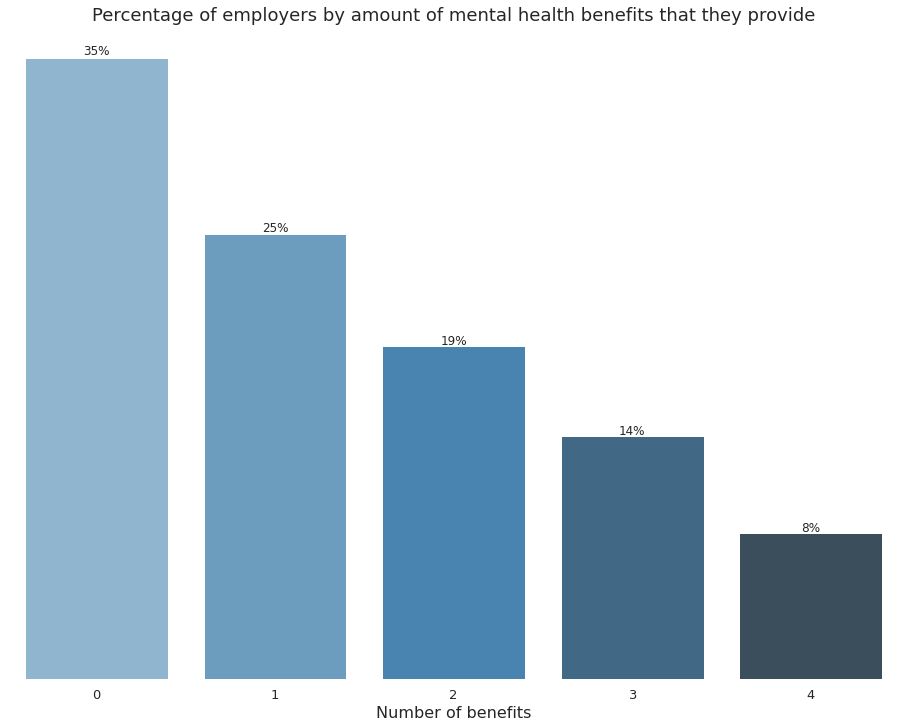

In [ ]:
plt.figure(figsize=(16, 12))
df3_1 = df3.employer_score.value_counts(normalize=True).reset_index()
ax = sns.barplot(x="index", y="employer_score", data=df3_1, palette="Blues_d")

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f"{height:.0%}", (x + width / 2, y + height * 1.005), ha="center")

plt.yticks([])
plt.ylabel("")
plt.xlabel("Number of benefits", size=16)
plt.title(
    "Percentage of employers by amount of mental health benefits that they provide",
    fontsize=18,
)
plt.tick_params(labelsize=13)
sns.despine(bottom=True, left=True)

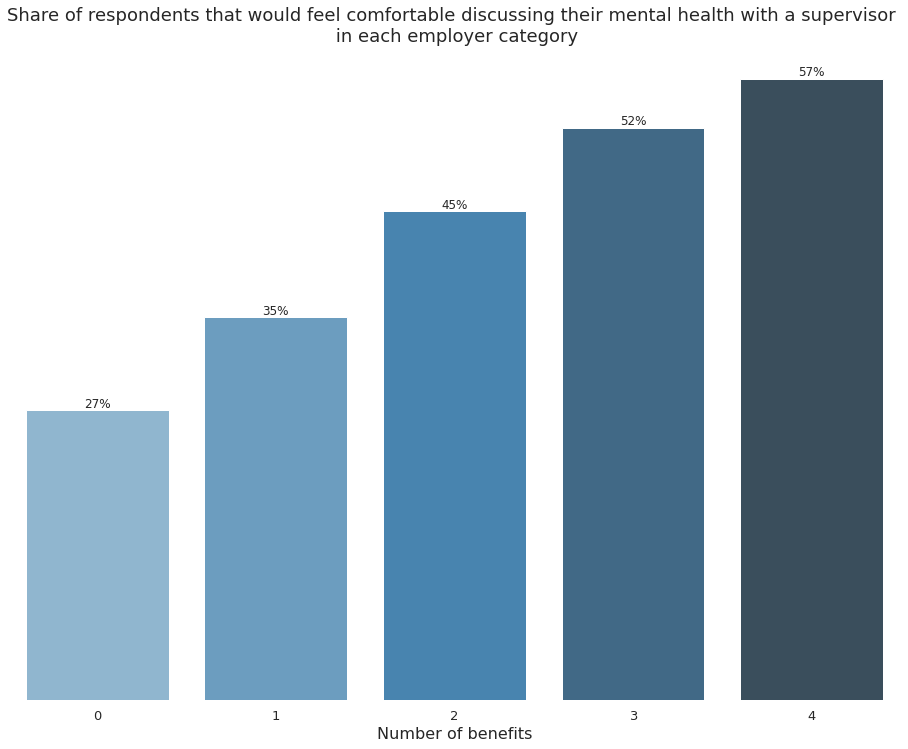

In [ ]:
df3_2 = df3[df3["discuss_mh_spr"] == "Yes"]
df3_2_1 = df3_2.groupby("employer_score")
a = df3.employer_score.value_counts().to_frame()
b = df3_2_1.discuss_mh_spr.count().to_frame()
df3_2_1 = pd.concat([a, b], axis=1)
df3_2_1["share_of_employees"] = df3_2_1["discuss_mh_spr"] / df3_2_1["employer_score"]
df3_2_1.reset_index(inplace=True)
df3_2_1 = df3_2_1.rename(columns={"index": "benefit_count"})

plt.figure(figsize=(16, 12))
ax = sns.barplot(
    x="benefit_count", y="share_of_employees", data=df3_2_1, palette="Blues_d"
)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f"{height:.0%}", (x + width / 2, y + height * 1.005), ha="center")

plt.yticks([])
plt.ylabel("")
plt.xlabel("Number of benefits", size=16)
plt.title(
    "Share of respondents that would feel comfortable discussing their mental health with a supervisor \n in each employer category",
    fontsize=18,
)
plt.tick_params(labelsize=13)
sns.despine(bottom=True, left=True)

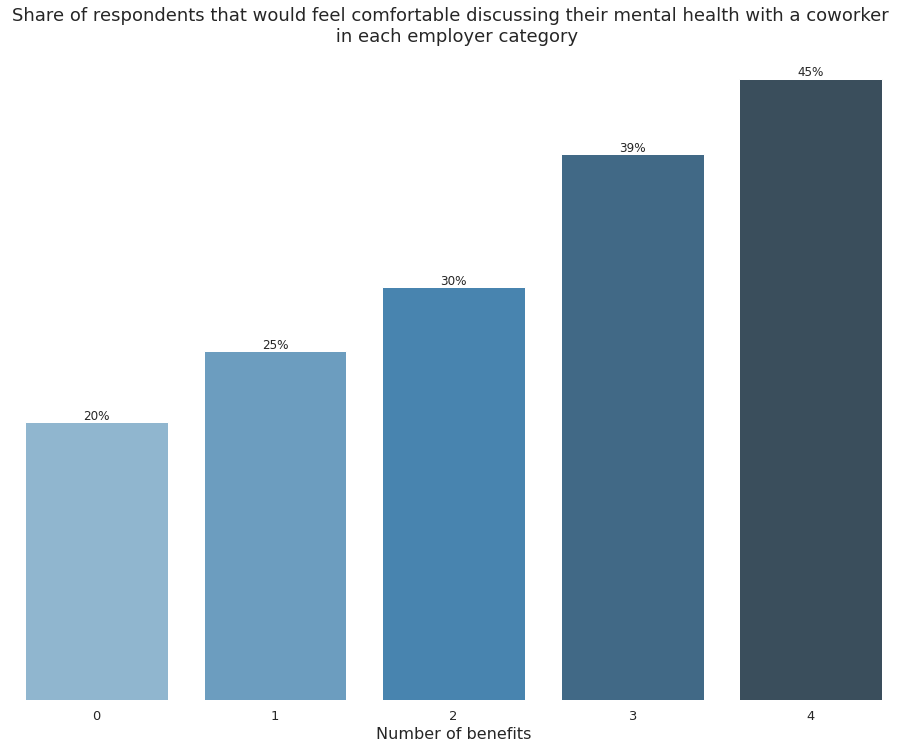

In [ ]:
df3_2 = df3[df3["discuss_mh_cw"] == "Yes"]
df3_2_1 = df3_2.groupby("employer_score")
a = df3.employer_score.value_counts().to_frame()
b = df3_2_1.discuss_mh_cw.count().to_frame()
df3_2_1 = pd.concat([a, b], axis=1)
df3_2_1["share_of_employees"] = df3_2_1["discuss_mh_cw"] / df3_2_1["employer_score"]
df3_2_1.reset_index(inplace=True)
df3_2_1 = df3_2_1.rename(columns={"index": "benefit_count"})

plt.figure(figsize=(16, 12))
ax = sns.barplot(
    x="benefit_count", y="share_of_employees", data=df3_2_1, palette="Blues_d"
)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f"{height:.0%}", (x + width / 2, y + height * 1.005), ha="center")

plt.yticks([])
plt.ylabel("")
plt.xlabel("Number of benefits", size=16)
plt.title(
    "Share of respondents that would feel comfortable discussing their mental health with a coworker \n in each employer category",
    fontsize=18,
)
plt.tick_params(labelsize=13)
sns.despine(bottom=True, left=True)

In [ ]:
print("Correlation between number of benefits provided and respondent willingness to discuss mental health with their supervisor:\n", df3_2_1["share_of_employees"].corr(df3_2_1["benefit_count"]))


Correlation between number of benefits provided and respondent willingness to discuss mental health with their supervisor:
 0.992515924837641


### Results



*   Health insurance covers mental health issues for 55% of respondents; 42.5% of those who have this benefit are comfortable speaking with their supervisors about mental health issues
*   In the survey, 60% of respondents said their employers provided one or fewer mental health benefits, while 22% said they provided three or more
*   A respondents willingness to discuss their mental health with their supervisor or coworker is strongly correlated with the number of mental health benefits provided




## Those with mental health issues, what mental health illness do they have?

In [ ]:
q1_3 = pd.read_sql(
      """ WITH table1 AS(
                SELECT DISTINCT UserID
                FROM Answer
                  WHERE (questionid = 32 OR questionid = 33 OR questionid = 34)
                    AND AnswerText = "Yes"
                ),
                table2 AS(
                SELECT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 115),
                table3 AS(
                SELECT UserID, AnswerText
                FROM Answer
                  WHERE questionid = 116)
          SELECT t2.AnswerText as diagnosed,
                 t3.AnswerText as presume
          FROM table2 t2
          JOIN table1 t1
          ON t1.UserID = t2.UserID
          JOIN table3 t3
          ON t3.UserID = t2.UserID
      """,
      con,
      )
q1_3.head()

,diagnosed,presume
0,-1,-1
1,"Anxiety Disorder (Generalized, Social, Phobia,...",-1
2,"Mood Disorder (Depression, Bipolar Disorder, etc)",-1
3,"Anxiety Disorder (Generalized, Social, Phobia,...",-1
4,"Mood Disorder (Depression, Bipolar Disorder, etc)",-1


In [ ]:
q1_3["diagnosed"] = q1_3["diagnosed"].str.replace("[\(\[].*?[\)\]]|-1", "", regex=True)
q1_3["presume"] = q1_3["presume"].str.replace("[\(\[].*?[\)\]]|-1", "", regex=True)
q1_3["diagnosis"] = q1_3["diagnosed"] + q1_3["presume"]
q1_3 = q1_3.drop(columns=["diagnosed", "presume"])
q1_3 = q1_3[q1_3.diagnosis != ""]
q1_3.head()

,diagnosis
1,Anxiety Disorder
2,Mood Disorder
3,Anxiety Disorder
4,Mood Disorder
5,Anxiety Disorder


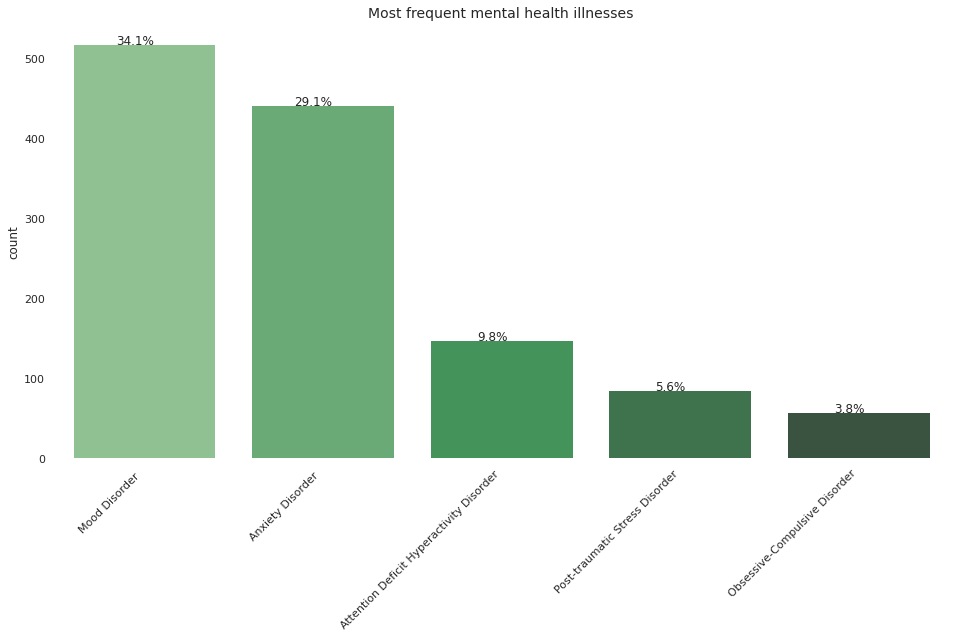

In [ ]:
plt.figure(figsize=(16,8))
axe = sns.countplot(
    x="diagnosis",
    data=q1_3,
    palette="Greens_d",
    order=q1_3.diagnosis.value_counts().iloc[:5].index,
)
diagnosis_list = list(q1_3.diagnosis.value_counts().iloc[:5].index)

total = len(q1_3["diagnosis"])
for p in axe.patches:
    percentage = "{:.1f}%".format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    axe.annotate(percentage, (x, y), ha="center", size=12)

plt.title("Most frequent mental health illnesses", fontsize=14)
sns.despine(bottom=True, left=True)
axe.set_xticklabels(diagnosis_list, rotation=45, ha="right")
plt.xlabel("")
plt.show()

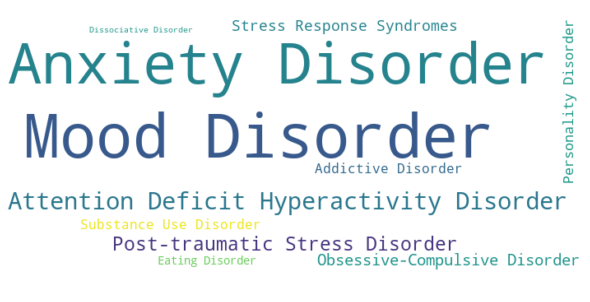

In [ ]:
word_could_dict = Counter(q1_3.diagnosis)

wordcloud = WordCloud(
    width=700, height=350, background_color="white", min_font_size=10
).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

## Conclusion


The purpose of this project was to determine what increases a person's comfort with discussing mental health issues at work.

The first thing that I want to highlight is that there is a lack of a balanced demographic breakdown in this survey, i.e. the gender breakdown is skewed towards men, and the age breakdown is predominantly young adults.  Therefore, there is a good chance that the data is skewed on many variables, so we can't really generalize from it.

We failed to conclude that a mental health diagnosis has an impact on one's willingness to discuss their mental health in the workplace. However, those with a diagnosed mental health condition are less likely to bring that up in an interview. 

Not many employers understand that they should invest in their employee mental wellbeing and develop mental health friendly culture. Only 40% of employers provide 3 or more mental health benefits. The rate of respondents who would feel comfortable discuss their mental health in the workplace is much higher amongst employers who invest in their employee mental health. Thus, we can assume that workplace culture has a significant impact on a person's willingness to discuss their mental health in the workplace.

It is also worth mentioning that most popular mental health illnesses amogst the respondents were Mood and Anxiety disorders, and ADHD.

The analysis could be improved with additional data, where demographic breakdown is more balanced. That would allow to make more generalised conclusions.